In [1]:
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_Basic, RPS_Basic_Multirun  # Importing RPS_Basic class from rps_base.py
from rps_simulation.learning_curves import sigmoid_skill_update, exponential_skill_update, richards_skill_update 
from rps_simulation.forgetting_curves import exponential_forgetting 
from rps_simulation.practice_rate import simple_linear_rate 
from rps_simulation.waiting_times import exponential_waiting_time 

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10)


We imported different learning functions above

# 1. RPS_Basic Class:

This class generates one instance of the Basic RPS Model. The waiting time distributions, skill update function derived from the learning curve, forgetting rates and practice_rate equation have to be provided and can all be changed:


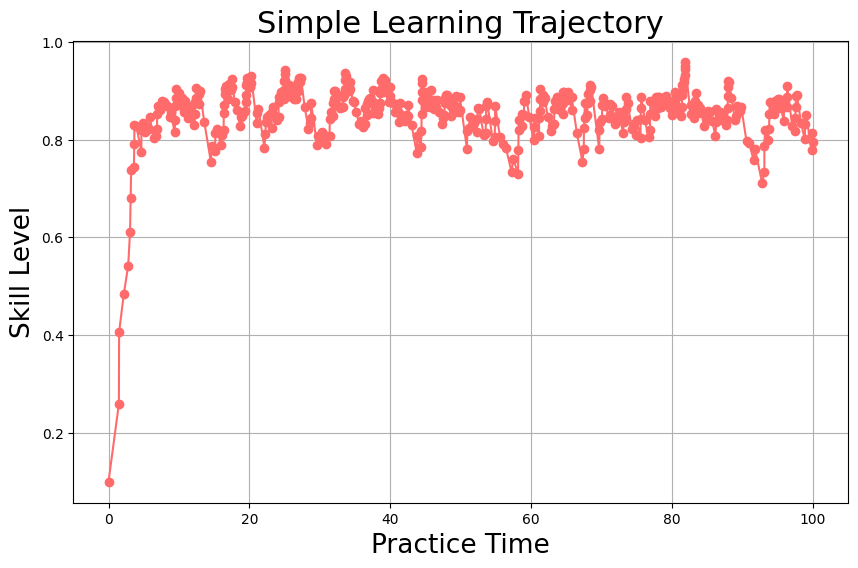

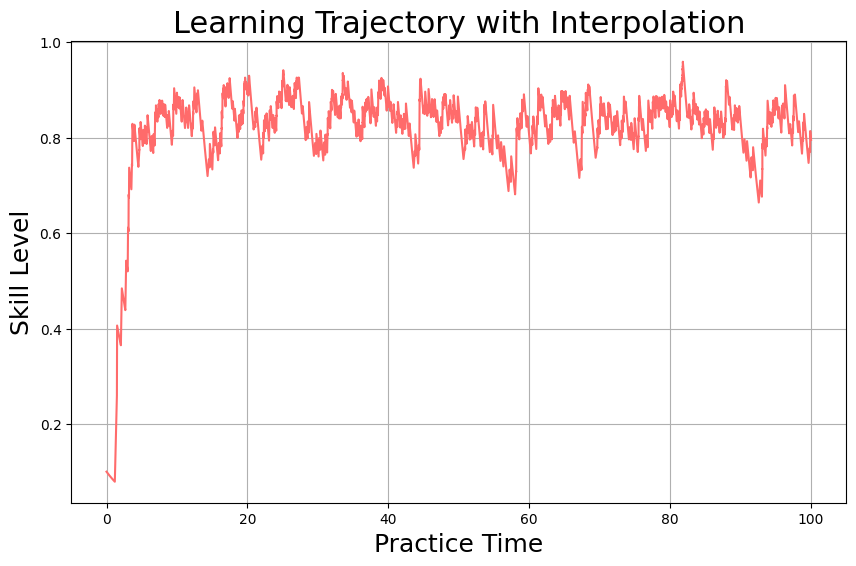

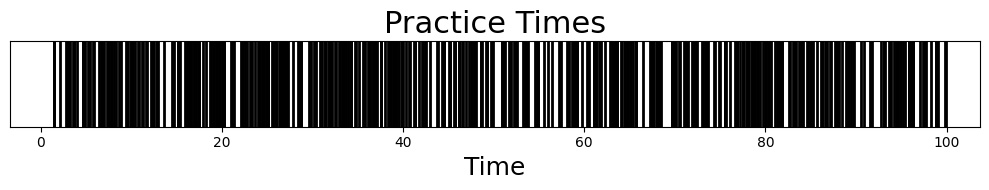

dict_keys(['final_skill', 'final_practice_rate', 'total_practice_events', 'time_lags', 'practice_times', 'skill_levels', 'practice_rates'])

In [2]:
"""
Instantiate a version of the RPS_Basic model with DEFAULT PARAMETERS:   
    exponential waiting time, concave learning function, exponential forgetting and a simple practice function = a + bS

So sample_concave = RPS_Basic() will do the same as the lie below:
"""

sample_concave = RPS_Basic(waiting_time_dist=exponential_waiting_time,
                 skill_update_func=exponential_skill_update,
                 forgetting_func=exponential_forgetting,
                 practice_rate_func=simple_linear_rate)


# run simulation:
sample_concave.run_simulation()

# simple learning trajectory with markers for practice events:
sample_concave.plot_simple_trajectory()

# plot trajectory
sample_concave.plot_learning_trajectory()

# Can also generate timestamp plots of when practice_events occured:
sample_concave.practice_times_plot()


# Get data form the simulation run and collect it in a dictionary
sample_data = sample_concave.data()
sample_data.keys()

# 2. RPS_Basic_Multirun
## 2.1 Concave Simulation and Plots



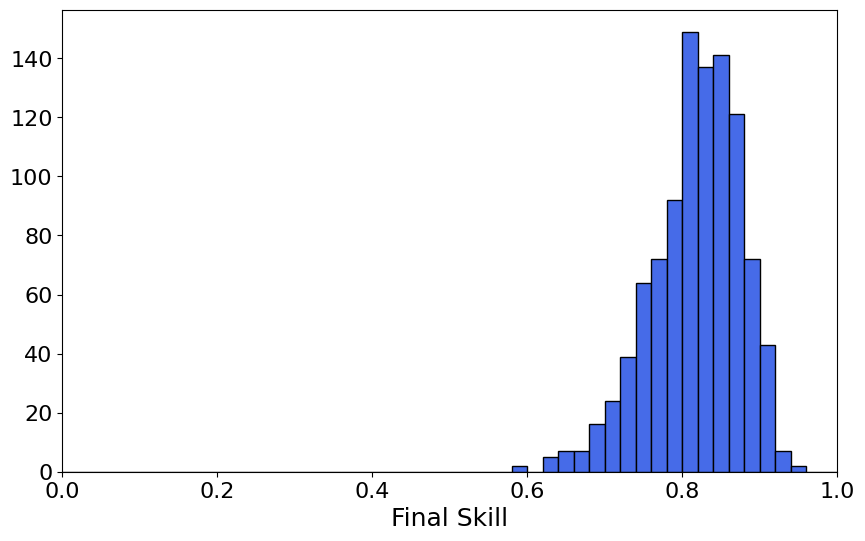

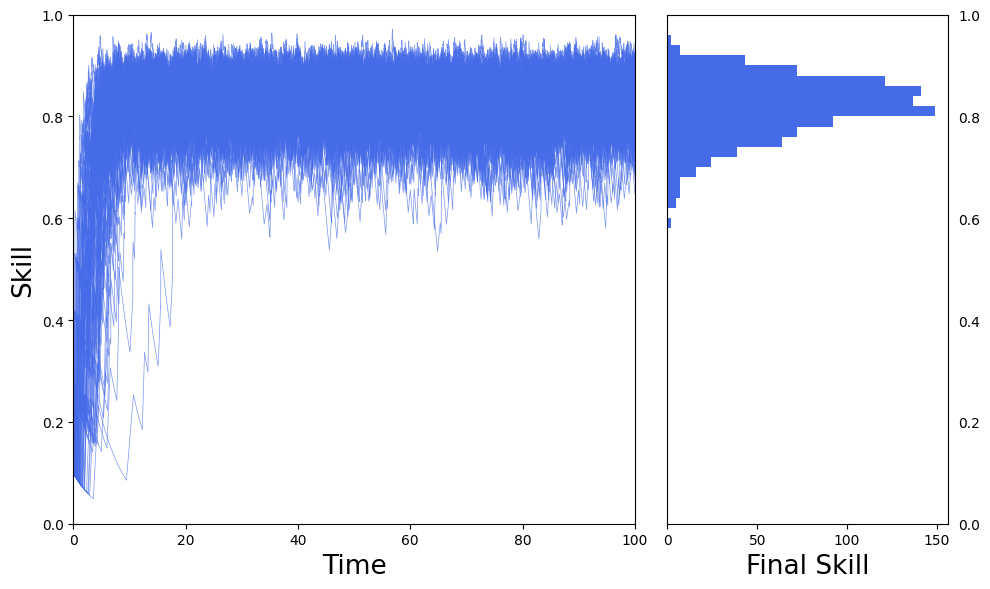

In [3]:
########## Concave Simulation and Plots ##########

# initializing the class
concave_sims = RPS_Basic_Multirun(waiting_time_dist=exponential_waiting_time,
                                skill_update_func=exponential_skill_update,
                                 forgetting_func=exponential_forgetting,
                                 practice_rate_func=simple_linear_rate,
                                 n_sims=1000)
# running the simulations
concave_sims.run_multiple_sims() 

concave_colour = '#466be8'
# plot final skill histogram:
concave_sims.plot_final_skill_histogram(colour=concave_colour)
 
# combined_plot
concave_sims.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, n_plots=100, save_location='../plots/concave_sim_summary.png')



## 2.2 Sigmoid Simulation and Plots

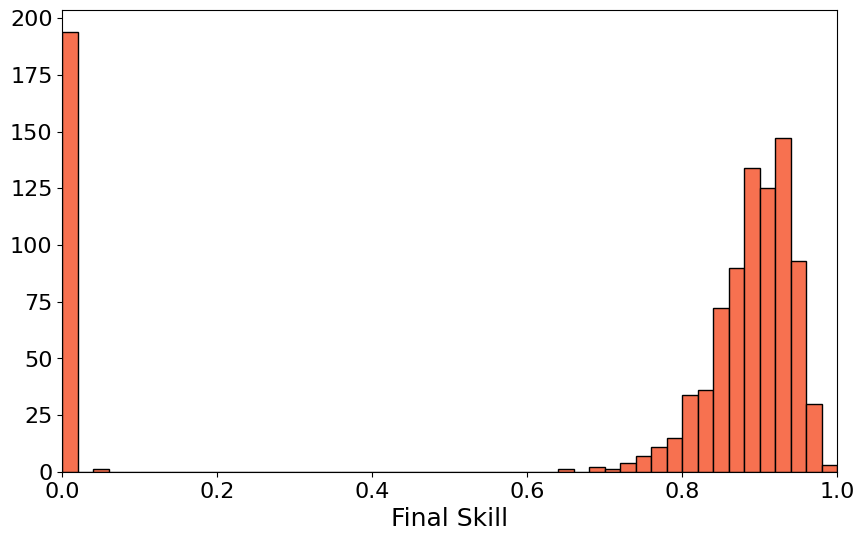

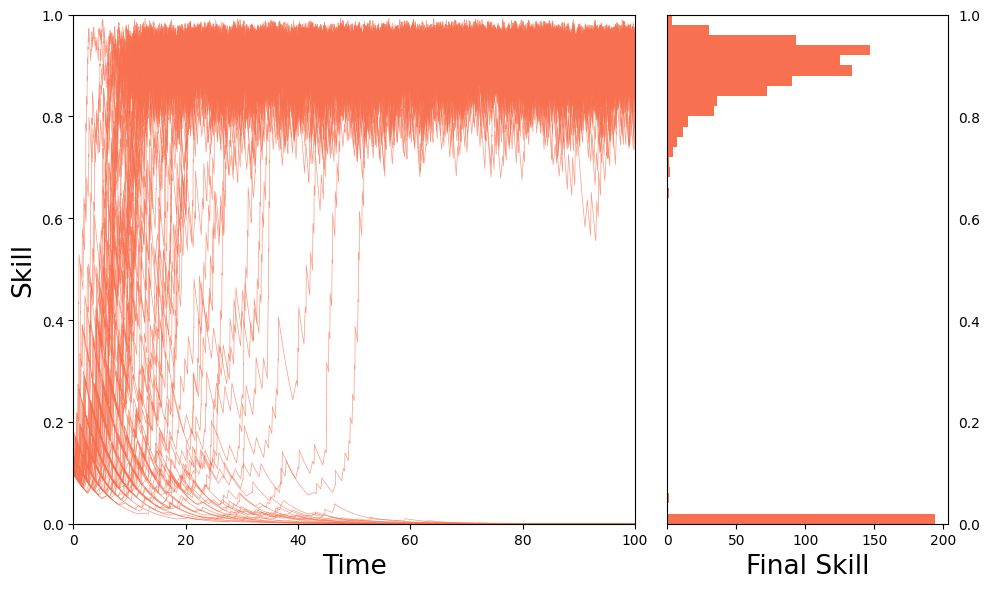

In [4]:
# initializing the class
sigmoid_sims = RPS_Basic_Multirun(waiting_time_dist=exponential_waiting_time,
                                skill_update_func=sigmoid_skill_update,
                                 forgetting_func=exponential_forgetting,
                                 practice_rate_func=simple_linear_rate,
                                 n_sims=1000)
# running the simulations
sigmoid_sims.run_multiple_sims() 

sigmoid_colour = '#f77150'
# plot final skill histogram:
sigmoid_sims.plot_final_skill_histogram(colour=sigmoid_colour)

# combined_plot
sigmoid_sims.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour, n_plots=100, save_location='../plots/sigmoid_sim_summary.png')


# 3. Effect of Different Practice Rate Equations:
## 3.1 Simple Linear Practice Rate:
The *simple_linear_rate* practice function used the equation $\lambda = a + bS$  to calculate the practice rate. Thus the higher the current skill, the higher the pratice rate (motivation) of a learner. This is not very realistic since because practice rate may also depend on whether the learner is improving or getting worse. Think of a highly motivated learner of chess who improve their skill (ELO rating) rapidly in the beginning. As learning reaches a plateau they may be less motivated than before, although they now have higher skill. Such scenarios can be captured by modifying the practice rate equation. 

## 3.2 Linear Practice Rate plus Change:
The practice rate function *linear_rate_plus_change* uses the equation (Default $a=0.2, b=5, c=1$):
$$\lambda = a  + bS + c(S - S_{prev})$$

The third term $c(S-S_{prev})$ adds the (weighted) difference of skill after previous practice-event ($S_{prev}$)  from the skill just after the current practice-event ($S$). If the current skill is higher, the learner is improving and it has a motivating effect and increases practice rate. If the current skill is lower than before, this has a demotivating effect and decreases the practice rate.

## 3.3 General Linear Practice Rate:
Both the cases above are special cases of the current practice rate $\lambda$ being a linear sum of skill history. Let the vector $\mathbf{S} = (S_0, S_1, \dots , S_n)$ be the vector (python list) of skills measured at each practice-event. Here $S_0$ is the initial skill, $S_1$ the skill after first practice-event and so on. $S_n$ is the skill after the current practice-event (so there have been $n$ practice events so far). 

The practice rate equation above can be re-written as:
* $\lambda = a + bS_n$ in case **3.1** (simple linear practice rate)
* $\lambda = a + (b+c)S_n + (-c)S_{n-1}$ in case **3.2** (linear practice rate plus change)

Both of these are general cases of general equation:
\begin{equation}
\lambda = w_0 + w_1 \cdot S_n + w_2 \cdot S_{n-1} + \cdots + w_k \cdot S_{n-k+1}
\end{equation}


Here, $\mathbf{w} = (w_0, w_1, \dots, w_k)$ is the vector (python list) of weights. $w_0$ is the constant term (same as $a$ above). $w_1$ is the weight given to the current skill $S_n$, $w_2$ the weight of skill $S_{n-1}$ and so on. The current skill $S_n$ and the previous $k-1$ skills $\{ S_{n-1}, S_{n-2}, \dots ,  S_{n-(k-1)} \}$ are used in the computation of the practice rate. 

**Example:** Suppose you want the current practice rate to only depend on the current skill $S_n$ and previous 2 skills (if they exist) $\{ S_{n-1}, S_{n-2} \}$. Then define $\mathbf{w} = (w_0, w_1, w_2, w_3)$ as the weights matrix. The function *general_linear_practice_rate* returns the practice rate using the general equation.



In [5]:
from rps_simulation.practice_rate import linear_rate_plus_change, general_linear_rate

skill_history = [0.1, 0.2, 0.3, 0.4, 0.5]
weights = [2, 1, 0.5, 0.25]

# practice rate can't go below min_rate=0.01 by Default, since it has to be positive
rate = general_linear_rate(skill_history, weights, min_rate=0.01) 

print('Practice Rate: ' + str(rate))


Practice Rate: 2.775


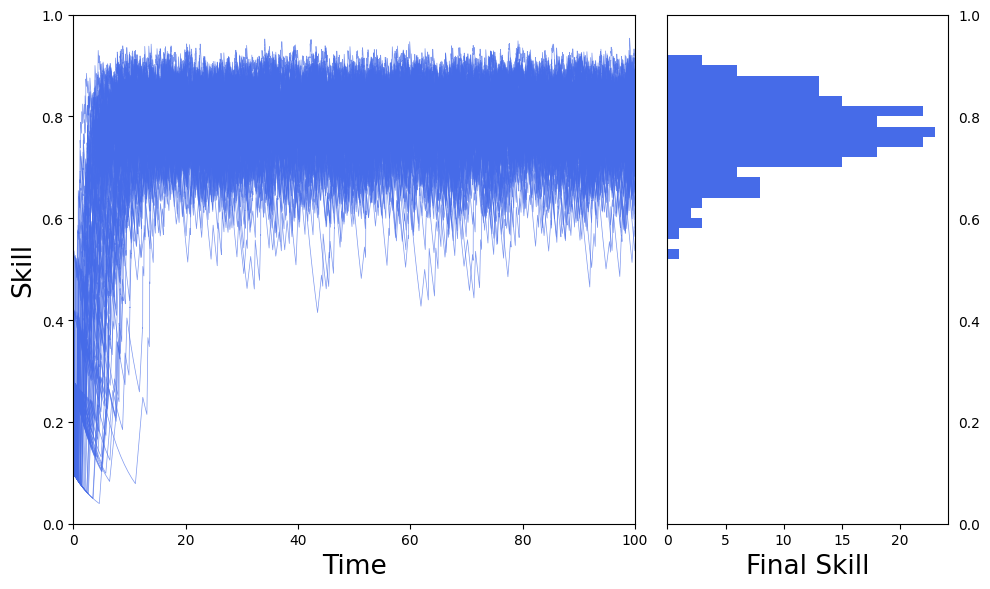

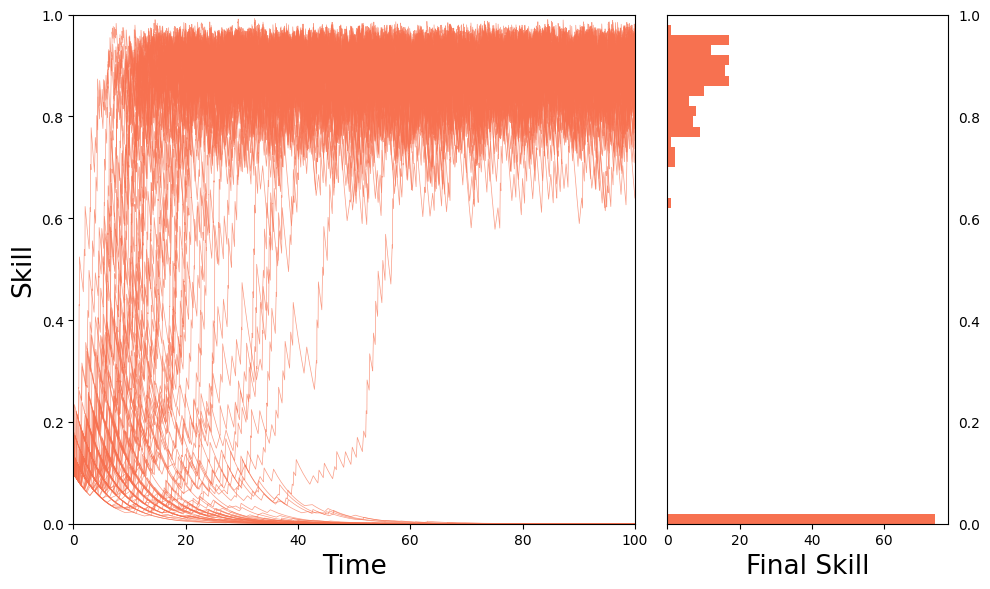

In [6]:
# Running sims with linear_rate_plus_change as the practice rate function: 
concave_sims_pr1 = RPS_Basic_Multirun(waiting_time_dist=exponential_waiting_time,
                                 skill_update_func=exponential_skill_update,
                                 forgetting_func=exponential_forgetting,
                                 practice_rate_func=lambda s: linear_rate_plus_change(s, a=0.2, b=4, c=2),
                                 n_sims=200)

sigmoid_sims_pr1 = RPS_Basic_Multirun(waiting_time_dist=exponential_waiting_time,
                                 skill_update_func=sigmoid_skill_update,
                                 forgetting_func=exponential_forgetting,
                                 practice_rate_func=lambda s: linear_rate_plus_change(s, a=0.2, b=4, c=2),
                                 n_sims=200)
# running the simulations
concave_sims_pr1.run_multiple_sims() 
sigmoid_sims_pr1.run_multiple_sims() 

# combined_plots:
concave_sims_pr1.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, n_plots=100, save_location='../plots/concave_sim_pr1_summary.png')
sigmoid_sims_pr1.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour, n_plots=100, save_location='../plots/sigmoid_sim_pr1_summary.png')
